In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

import os
os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/')


from bokeh.models import HoverTool
from bokeh.core.properties import value


import time
# 导入时间模块

Loading BokehJS ...

In [94]:
# 1、财富分配模型测试
# 模型假设：
# ① 每个人初始基金100元
# ② 从18岁到65岁，每天玩一次，简化运算按照一共玩17000天
# ③ 每天拿出一元钱，并且随机分配给另一个人
# ④ 当某人的财富值降到0元时，他在该轮无需拿出1元钱给别人，但仍然有机会得到别人给出的钱
# （1） 模拟第一轮游戏分配
# 先不考虑某人财富值降到0元的情况

person_n = [x for x in range(1,101)]
#100个人的名单，以数字1~100表示

fortune = pd.DataFrame([100 for i in range(100)],index = person_n)
fortune.index.name = 'id'
#index就是人，0列对应的数据为初始基金

round_r1 = pd.DataFrame({'lost':1,'pre_round':fortune[0]})
choice_r1 = pd.Series(np.random.choice(person_n,100))
gain_r1 = pd.DataFrame({'gain':choice_r1.value_counts()})
round_r1 = round_r1.join(gain_r1)
round_r1.fillna(0,inplace = True)
#lost代表拿出一元，gain代表随机获得x元，pre_round代表初始基金

fortune[1] = round_r1['pre_round'] - round_r1['lost'] + round_r1['gain']
fortune.head()

,0,1
id,,
1,100,101.0
2,100,99.0
3,100,99.0
4,100,99.0
5,100,100.0


In [123]:
# （2） 模拟第一轮游戏分配
# 考虑情况：当某人的财富值降到0元时，他在该轮无需拿出1元钱给别人，但仍然有机会得到别人给出的钱

person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for i in range(100)],index = person_n)
fortune.index.name = 'id'

round_r1 = pd.DataFrame({'pre_round':fortune[0],'lost':0})
round_r1['lost'][round_r1['pre_round']>0] = 1
round_players = round_r1[round_r1['pre_round']>0]

choice_r1 = pd.Series(np.random.choice(person_n,len(round_players)))
gain_r1 = pd.DataFrame({'gain':choice_r1.value_counts()})
round_r1 = round_r1.join(gain_r1)
round_r1.fillna(0,inplace = True)

fortune[1] = round_r1['pre_round'] - round_r1['lost'] + round_r1['gain']
fortune.head()

,0,1
id,,
1,100,99.0
2,100,100.0
3,100,100.0
4,100,99.0
5,100,100.0


In [14]:
# （3）构建函数模型
# 这里注意：当某人的财富值降到0元时，他在该轮无需拿出1元钱给别人，但仍然有机会得到别人给出的钱

def game1(data,roundi):
    if len(data[data[roundi-1]==0])>0:
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':0})
        round_i['lost'][round_i['pre_round']>0] = 1
        round_players_i = round_i[round_i['pre_round']>0]
        choice_i = pd.Series(np.random.choice(person_n,len(round_players_i)))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace = True)
        return(round_i['pre_round'] - round_i['lost'] + round_i['gain'])
    else:
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':1})
        choice_i = pd.Series(np.random.choice(person_n,100))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace = True)
        return(round_i['pre_round'] - round_i['lost'] + round_i['gain'])

       
person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for i in range(100)],index = person_n)
fortune.index.name = 'id'

starttime = time.time()

for n in range(1,17001):
    fortune[n] = game1(fortune,n)

game1_result = fortune.T
endtime = time.time()

print('模型总共用时%i秒' % (endtime - starttime))
game1_result.tail()

模型总共用时513秒


id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
16996,49.0,50.0,91.0,123.0,129.0,46.0,30.0,191.0,29.0,319.0,...,323.0,59.0,206.0,242.0,30.0,92.0,72.0,7.0,2.0,20.0
16997,50.0,49.0,90.0,124.0,130.0,46.0,31.0,190.0,31.0,319.0,...,323.0,59.0,206.0,243.0,30.0,91.0,72.0,6.0,1.0,21.0
16998,52.0,49.0,90.0,123.0,132.0,45.0,31.0,193.0,30.0,318.0,...,324.0,61.0,205.0,242.0,30.0,93.0,72.0,6.0,0.0,21.0
16999,51.0,48.0,91.0,123.0,132.0,46.0,32.0,194.0,29.0,319.0,...,323.0,62.0,206.0,242.0,30.0,92.0,73.0,5.0,2.0,21.0
17000,53.0,47.0,91.0,123.0,134.0,46.0,34.0,194.0,29.0,318.0,...,323.0,61.0,207.0,242.0,30.0,94.0,72.0,4.0,1.0,21.0


In [17]:
# （5）绘制柱状图
# ** 前100轮，按照每10轮绘制一次柱状图，查看财富变化情况
# ** 100至1000轮，按照每100轮绘制一次柱状图，查看财富变化情况
# ** 1000至17000轮，按照每400轮绘制一次柱状图，查看财富变化情况
# ① 不排序绘制



os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/练习绘图/财富分配模型_初始模型_不排序绘制/')

def graph1(data,start,end,length):
    for n in list(range(start,end,length)):
        datai = data.iloc[n]
        plt.figure(figsize = (10,6))
        plt.bar(datai.index,datai.values,color = 'gray',alpha = 0.8,width = 0.9)
        plt.xlim((-10,110))
        plt.ylim((0,400))
        plt.xlabel('PlayersID')
        plt.ylabel('Fortune')
        plt.title('Round%d'%n)
        plt.grid(color = 'gray',linestyle = '--',linewidth = 0.5)
        plt.savefig('graph1_round_%d.png'%n,dpi = 200)

graph1(game1_result,0,100,10)
graph1(game1_result,100,1000,100)
graph1(game1_result,1000,17400,400)

In [ ]:
os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/练习绘图/财富分配模型_初始模型_排序绘制/')

def graph1(data,start,end,length):
    for n in list(range(start,end,length)):
        datai = data.iloc[n].sort_values().reset_index()[n]
        plt.figure(figsize = (10,6))
        plt.bar(datai.index,datai.values,color = 'gray',alpha = 0.8,width = 0.9)
        plt.xlim((-10,110))
        plt.ylim((0,400))
        plt.xlabel('PlayersID')
        plt.ylabel('Fortune')
        plt.title('Round%d'%n)
        plt.grid(color = 'gray',linestyle = '--',linewidth = 0.5)
        plt.savefig('graph1_round_%d.png'%n,dpi = 200)

graph1(game1_result,0,100,10)
graph1(game1_result,100,1000,100)
graph1(game1_result,1000,17400,400)

In [30]:
# 一些结论

round_17000_1 = pd.DataFrame({'money':game1_result.iloc[17000]}).sort_values('money',ascending = False).reset_index()
round_17000_1['fortune_pre'] = round_17000_1['money'] / round_17000_1['money'].sum()
round_17000_1['fortune_cumsum'] = round_17000_1['fortune_pre'].cumsum()

round_17000_1.head()
# 最后一轮中，最富有的人财富值为365元，相比于初始财富，翻了3.65倍
# 10%的人掌握着28%的财富，20%的人掌握着51%的财富？
# 60%的人财富缩水至100元以下了

,id,money,fortune_pre,fortune_cumsum
0,84,333.0,0.0333,0.0333
1,91,323.0,0.0323,0.0656
2,10,318.0,0.0318,0.0974
3,75,285.0,0.0285,0.1259
4,19,251.0,0.0251,0.1510


In [ ]:
'''

2、在允许借贷情况下，研究以下问题
和初始模型的区别：
允许借贷意味着可以找亲友、银行、投资人借贷 → 资产为负时，仍然参与游戏
要求：
① 构建模型模拟，再次模拟财富分配情况
   ** 最富有的人相比于初始财富，翻了多少倍？
   ** 10%的人掌握着多少的财富？30%的人掌握着多少的财富？又有百分之多少人财富缩水至100元以下了？
② 绘制柱状图，查看该轮财富情况
   ** 横轴标签代表一个玩家的编号，柱子的高低变动反映该玩家财富值的变化
   ** 这里只需要每轮按照财富值排序绘制
   ** 前100轮，按照每10轮绘制一次柱状图，查看财富变化情况
   ** 100至1000轮，按照每100轮绘制一次柱状图，查看财富变化情况
   ** 1000至17000轮，按照每400轮绘制一次柱状图，查看财富变化情况
③ 游戏次数与财富分布的标准差的情况，绘图来表示
   ** 这里用允许借贷情况下模拟的结果
   ** 横坐标为游戏次数（总共17000次），纵坐标为财富分配标准差
   ** 绘制折线图
④ 玩家从18岁开始，在经过17年后为35岁，这个期间共进行游戏6200次左右，则此刻查看财富情况，将财富值为负的标记成“破产”，通过图表研究
   该类玩家在今后的游戏中能否成功“逆袭”（财富值从负到正为逆袭）、
   ** 这里绘制柱状图 → 6200至17000轮，按照每500轮绘制一次柱状图
提示：
① 该模型只需要将初始模型中，“财富小于零时无需拿钱给别人”的条件删掉即可
② 最后绘制柱状图时，需要将负债的玩家标红，这里可以通过截取dataframe之后，给与color字段来设置颜色


'''

In [2]:
'''
（1）构建函数模型

'''
# 这里注意：当某人的财富值降到0元时，他在该轮无需拿出1元钱给别人，但仍然有机会得到别人给出的钱

def game2(data,roundi):
    round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':1})
    choice_i = pd.Series(np.random.choice(person_n,100))
    gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
    round_i = round_i.join(gain_i)
    round_i.fillna(0,inplace = True)
    return round_i['pre_round'] - round_i['lost'] + round_i['gain']



'''
（2）运行模型，模拟财富分配

'''

person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for x in range(100)],index = person_n)
fortune.index.name = 'id'

start = time.time()
for n in range(1,17001):
    fortune[n] = game2(fortune,n)
game2_result = fortune.T    
end = time.time()
print(end - start)

game2_result.tail()

88.38905572891235


id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
16996,-112.0,219.0,81.0,107.0,93.0,-4.0,266.0,101.0,139.0,251.0,...,228.0,244.0,70.0,154.0,189.0,-90.0,179.0,90.0,131.0,-35.0
16997,-113.0,218.0,81.0,107.0,93.0,-3.0,266.0,102.0,140.0,252.0,...,229.0,243.0,70.0,154.0,188.0,-89.0,179.0,90.0,130.0,-34.0
16998,-111.0,218.0,81.0,108.0,92.0,-4.0,267.0,101.0,140.0,251.0,...,229.0,243.0,69.0,154.0,188.0,-90.0,181.0,90.0,129.0,-33.0
16999,-109.0,219.0,82.0,108.0,91.0,-3.0,266.0,101.0,139.0,250.0,...,228.0,243.0,68.0,154.0,188.0,-89.0,180.0,89.0,130.0,-34.0
17000,-109.0,218.0,81.0,108.0,90.0,-4.0,268.0,100.0,139.0,251.0,...,228.0,243.0,67.0,154.0,187.0,-89.0,180.0,89.0,132.0,-33.0


In [3]:
# 一些结论
round_17000_2 = pd.DataFrame({'money':game2_result.iloc[17000]}).sort_values('money',ascending = False).reset_index()
round_17000_2['fortune_pre'] = round_17000_2['money'] / round_17000_2['money'].sum()
round_17000_2['fortune_cumsum'] = round_17000_2['fortune_pre'] .cumsum()

round_17000_2.head()

,id,money,fortune_pre,fortune_cumsum
0,71,441.0,0.0441,0.0441
1,69,373.0,0.0373,0.0814
2,44,344.0,0.0344,0.1158
3,47,333.0,0.0333,0.1491
4,36,314.0,0.0314,0.1805


In [131]:
'''
（3）游戏次数与财富分布的标准差的情况，绘图来表示
'''

os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/练习绘图/财富分配模型__允许借贷/')

def graph3(data,start,end,length):
    for n in list(range(start,end,length)):
        datai = data.iloc[n].sort_values().reset_index()[n]
        plt.figure(figsize = (10,6))
        plt.bar(datai.index,datai.values,color = 'gray',alpha = 0.8,width = 0.9)
        plt.xlim((-10,110))
        plt.ylim((-200,400))
        plt.xlabel('playerid')
        plt.ylabel('fortune')
        plt.title('Round%d'%n)
        plt.grid(color = 'gray',linewidth = 0.5,linestyle = '--')
        plt.savefig('graph1_round_%d.png'%n,dpi = 200)

graph3(game2_result,0,100,10)
graph3(game2_result,100,1000,100)
graph3(game2_result,1000,17400,400)

'\n（3）游戏次数与财富分布的标准差的情况，绘图来表示\n'

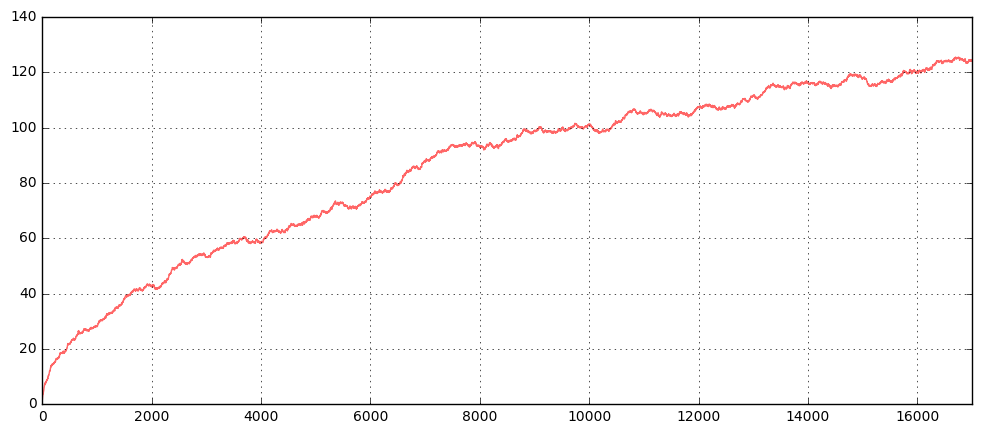

In [4]:
'''
（4）游戏次数与财富分布的标准差的情况，绘图来表示
'''

game2_st = game2_result.std(axis = 1)
game2_st.plot(color = 'red',alpha = 0.6,figsize = (12,5),grid = True)

# 而在6000-6500轮游戏后，标准差的变化趋于平缓，但仍在上升；
# 按照我们设定的游戏与人生的对应规则，这时玩家年龄为35岁

[72, 85, 59, 33, 8, 5, 64, 43, 16]


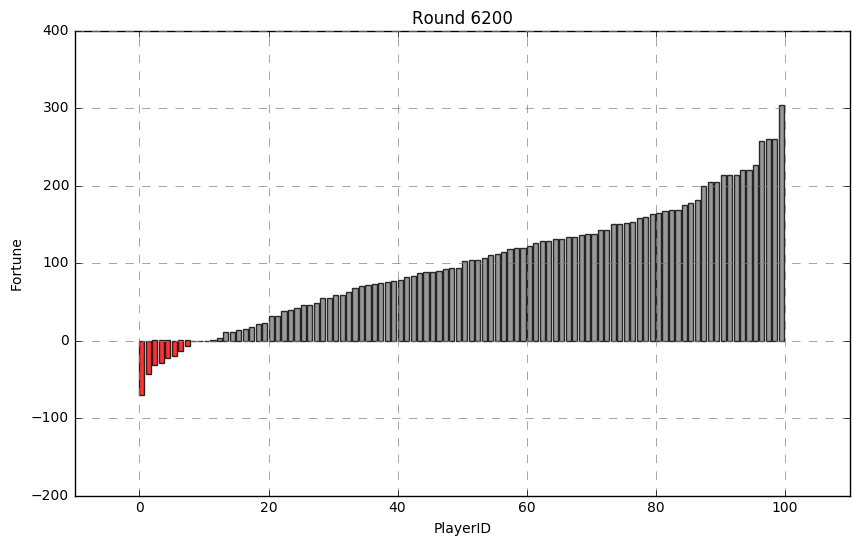

In [5]:
'''
（5）玩家从18岁开始，在经过17年后为35岁，这个期间共进行游戏6200次左右，则此刻查看财富情况，将财富值为负的标记成“破产

'''
# 通过图表研究该类玩家在今后的游戏中能否成功“逆袭”（财富值从负到正为逆袭）、
# 这里绘制折线图
game2_round6200 = pd.DataFrame({'money':game2_result.iloc[6200].sort_values().reset_index()[6200],
                                'id':game2_result.iloc[6200].sort_values().reset_index()['id'],
                                'color':'gray'})
game2_round6200['color'][game2_round6200['money']<0] = 'red'
id_pc = game2_round6200['id'][game2_round6200['money']<0].tolist()
print(id_pc)
# 筛选数据
# 设置颜色参数

plt.figure(figsize = (10,6))
plt.bar(game2_round6200.index,game2_round6200['money'],color = game2_round6200['color'],alpha = 0.8)
plt.xlim((-10,110))
plt.ylim((-200,400))
plt.xlabel('PlayerID')
plt.ylabel('Fortune')
plt.title('Round 6200')
plt.grid(color = 'gray',linestyle = '--',linewidth = 0.5)
plt.show()
#绘制柱状图

In [9]:
# 绘图分析

os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/练习绘图/财富分配模型_允许借贷_负债玩家逆袭/')

def graph4(data,start,end,length):
    for n in list(range(start,end,length)):
        datai = pd.DataFrame({'money':data.iloc[n],'color':'gray'})
        datai['color'].loc[id_pc] = 'red'
        datai = datai.sort_values('money').reset_index()
        plt.figure(figsize = (10,6))
        plt.bar(datai.index,datai['money'],color = datai['color'],alpha = 0.8,width = 0.9)
        plt.xlim((-10,110))
        plt.ylim((-200,400))
        plt.xlabel('PlayersID')
        plt.ylabel('Fortune')
        plt.title('Round%d'%n)
        plt.grid(color = 'gray',linestyle = '--',linewidth = 0.5)
        plt.savefig('graph4_round_%d.png'%n,dpi = 200)
# 创建绘图函数2

graph4(game2_result,6200,17000,500)

# 结论
# 以35岁为界，虽然破产以后，不足一半的概率回复到普通人的生活，但想要逆袭暴富，却是相当困难的

In [10]:
'''3、努力的人生会更好吗？
模型假设：
① 每个人初始基金仍为100元
② 一共玩17000轮
③ 每天拿出一元钱，并且随机分配给另一个人
④ 有10个人加倍努力，从而获得了1%的竞争优势
⑤ 允许借贷
允许借贷意味着可以找亲友、银行、投资人借贷 → 资产为负时，仍然参与游戏
要求：
① 构建模型模拟，再次模拟财富分配情况
② 努力的人，最后是否富有？
③ 绘制柱状图，查看该轮财富情况
   ** 横轴标签代表一个玩家的编号，柱子的高低变动反映该玩家财富值的变化
   ** 这里只需要每轮按照财富值排序绘制
   ** 前100轮，按照每10轮绘制一次柱状图，查看财富变化情况
   ** 100至1000轮，按照每100轮绘制一次柱状图，查看财富变化情况
   ** 1000至17000轮，按照每400轮绘制一次柱状图，查看财富变化情况
提示：
① 这里设置的10个人id分别为：[1,11,21,31,41,51,61,71,81,91]
② np.random.choice(person_n, p =[...]) → 这里通过设置p来修改概率：努力的10人概率为0.0101，其他人概率为（0.899/90）


'''

'3、努力的人生会更好吗？\n模型假设：\n① 每个人初始基金仍为100元\n② 一共玩17000轮\n③ 每天拿出一元钱，并且随机分配给另一个人\n④ 有10个人加倍努力，从而获得了1%的竞争优势\n⑤ 允许借贷\n允许借贷意味着可以找亲友、银行、投资人借贷 → 资产为负时，仍然参与游戏\n要求：\n① 构建模型模拟，再次模拟财富分配情况\n② 努力的人，最后是否富有？\n③ 绘制柱状图，查看该轮财富情况\n   ** 横轴标签代表一个玩家的编号，柱子的高低变动反映该玩家财富值的变化\n   ** 这里只需要每轮按照财富值排序绘制\n   ** 前100轮，按照每10轮绘制一次柱状图，查看财富变化情况\n   ** 100至1000轮，按照每100轮绘制一次柱状图，查看财富变化情况\n   ** 1000至17000轮，按照每400轮绘制一次柱状图，查看财富变化情况\n提示：\n① 这里设置的10个人id分别为：[1,11,21,31,41,51,61,71,81,91]\n② np.random.choice(person_n, p =[...]) → 这里通过设置p来修改概率：努力的10人概率为0.0101，其他人概率为（0.899/90）\n\n\n'

In [3]:
'''
（1）构建函数模型

'''

person_p = [0.899/90 for x in range(100)]
for i in [1,11,21,31,41,51,61,71,81,91]:
    person_p[i-1] = 0.0101

def game3(data,roundi):
    round_i = pd.DataFrame({'pre_round':data[roundi - 1],'lost':1})
    choice_i = pd.Series(np.random.choice(person_n,100,p = person_p))
    gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
    round_i = round_i.join(gain_i)
    round_i.fillna(0,inplace = True)
    return round_i['pre_round'] - round_i['lost'] + round_i['gain']

'''
（2）运行模型，模拟财富分配

'''
person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for x in range(100)],index = person_n)
fortune.index.name = 'id'

start = time.time()
for n in range(1,17001):
    fortune[n] = game3(fortune,n)
game3_result = fortune.T
end = time.time()
print(end-start)

87.70601630210876


In [5]:
'''
（3）绘图分析

'''
os.chdir('E:/学习资料/python数据分析/项目资料/项目13社会财富分配问题模拟/练习绘图/财富分配模型_努力人生/')

color_lst = []
def graph5(data,start,end,length):
    for n in list(range(start,end,length)):
        datai = pd.DataFrame({'money':data.iloc[n],'color':'gray'})
        datai['color'].loc[1,11,21,31,41,51,61,71,81,91] = 'red'
        datai = datai.sort_values('money',ascending = True).reset_index()
        plt.figure(figsize = (10,6))
        plt.bar(datai.index,datai['money'],color = datai['color'],alpha = 0.8,width = 0.9)
        plt.xlim((-10,110))
        plt.ylim((-200,400))
        plt.xlabel('PlayersID')
        plt.ylabel('Fortune')
        plt.title('Round%d'%n)
        plt.grid(color = 'gray',linestyle = '--',linewidth = 0.5)
        plt.savefig('graph5_round_%d.png'%n,dpi = 200)
        
graph5(game3_result,0,100,10)
graph5(game3_result,100,1000,100)
graph5(game3_result,1000,17400,400)

'\n（3）绘图分析\n\n'

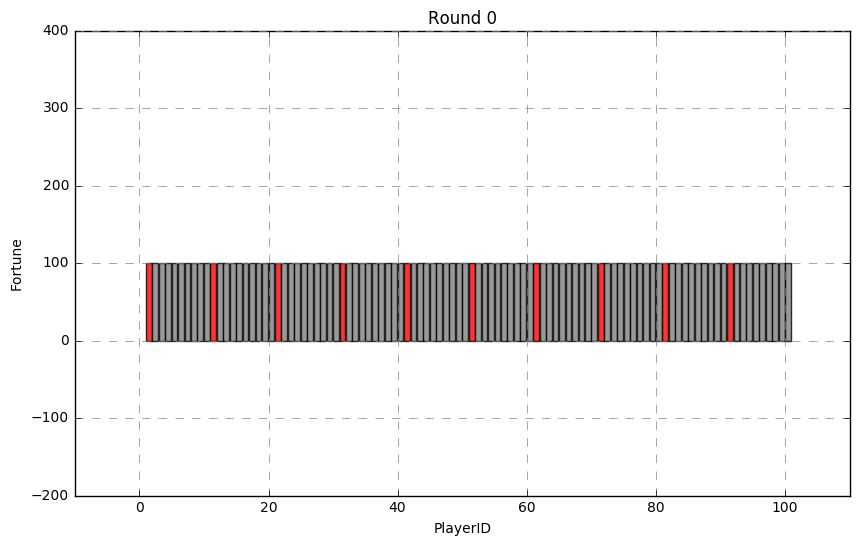

In [9]:

plt.figure(figsize = (10,6))
data0 = pd.DataFrame({'money':game3_result.iloc[0],'color':'gray'})
data0['color'].loc[[1,11,21,31,41,51,61,71,81,91]] = 'red'
plt.bar(data0.index,data0['money'],color=data0['color'],alpha = 0.8,width = 0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylim((-200,400))
plt.xlim((-10,110))
plt.title('Round %d' % 0)
plt.xlabel('PlayerID')
plt.ylabel('Fortune')
plt.savefig('graph5_round_%d.png' % 0, dpi=200)
# 绘制起始图片